In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import random
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from utils.load_networkx import networkx_feat
from utils.macro_dataset import MacroDataset
from utils import macro_unsupervised as unsup
from utils.macro_supervised import MacroSupervised
from utils.macro_attribution import Attribution
from utils import plot

Using backend: pytorch


**Filepaths**

MON_SMILES : .csv or .txt file of macromolecule monomers
<br>
BOND_SMILES : .csv or .txt file of macromolecule bonds

TXT_DATA_PATH : For dataset, to be used for training
<br>
DF_PATH : For dataset, to be used for graph labels during training
<br>
MODEL_PATH : For models, to be used when training to save the model, optimizer, and configuration file
<br>
FIG_PATH : For plots, to be used when saving ROC-AUC or parity plot figures

In [2]:
MON_SMILES = './tables/SMILES_glycans_monomer.txt'
BOND_SMILES = './tables/SMILES_glycans_bond.txt'

TXT_DATA_PATH = './dataset/classification/'
DF_PATH = './tables/glycobase_immuno_mini.txt'
MODEL_PATH = './'
FIG_PATH = './'

**Variables**

FEAT : Type of features for macromolecule monomers and bonds -- fingerprints ('fp') or one-hot encodings ('onehot') (default = 'fp')
<br>
FP_RADIUS_MON : Radius of topological exploration for monomer fingerprint (default = 3)
<br>
FP_BITS_MON : Size of fingerprint bit-vector for monomer (default = 128)
<br>
FP_RADIUS_BOND : Radius of topological exploration for bond fingerprint (default = 3)
<br>
FP_BITS_BOND : Size of fingerprint bit-vector for bond (default = 16)

SEED : Random seed for shuffling dataset (default = 108)
<br>
TASK : Learning task (classification, regression) (default = 'classification')
<br>
MODEL : Model architecture for supervised learning (Weave, MPNN, Attentive FP, GCN, GAT) (default = 'Weave')
<br>
LABELNAME : Name of label to classify (default = 'Immunogenic')
<br>
SPLIT : Proportion of the dataset to use for training, validation and test (default = '0.8,0.1,0.1')
<br>
NORM: Normalization method for regression labels -- quantile transform ('qt') or standard scaler ('ss') (default = 'qt')

NUM_EPOCHS: Maximum number of epochs allowed for training (default = 1000)
<br>
NUM_WORKERS: Number of processes for data loading (default: 1)

SAVE_MODEL: Whether to save full model file. Model state dict will be saved automatically (default = False)
<br>
SAVE_OPT: Whether to save optimizer files (default = False)
<br>
SAVE_CONFIG: Whether to save configuration file (default = False)

PLOT_TYPE: Dataset to plot ('val' for validation or 'test' for test)

CUSTOM_PARAMS: Dictionary of hyperparameters for model

In [3]:
FEAT = 'fp'
FP_RADIUS_MON = 3
FP_BITS_MON = 128
FP_RADIUS_BOND = 3
FP_BITS_BOND = 16

SEED = 108
TASK = 'classification'
MODEL = 'AttentiveFP'
LABELNAME = 'Immunogenic'
SPLIT = '0.6,0.2,0.2'
NORM = 'qt'

NUM_EPOCHS = 10
NUM_WORKERS = 1

SAVE_MODEL = False
SAVE_OPT = False
SAVE_CONFIG = False

PLOT_TYPE = 'val'

CUSTOM_PARAMS = {}

**Load featurized NetworkX graphs**

In [5]:
NX_GRAPHS = networkx_feat(
    TXT_DATA_PATH = TXT_DATA_PATH, 
    MON_SMILES = MON_SMILES, 
    BOND_SMILES = BOND_SMILES, 
    FEAT = FEAT, 
    FP_RADIUS_MON = FP_RADIUS_MON, 
    FP_RADIUS_BOND = FP_RADIUS_BOND, 
    FP_BITS_MON = FP_BITS_MON, 
    FP_BITS_BOND = FP_BITS_BOND
)

{0: 'Rha', 1: 'Gal', 2: 'Glc', 3: 'GlcA', 4: 'GalNAc', 5: 'Gal'}


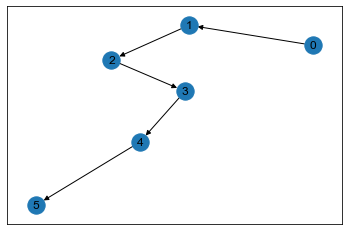

In [6]:
plot.graph(NX_GRAPHS['GBID10271'])

{0: 'Glc', 1: 'QuiNBut', 2: 'Glc', 3: 'GlcOAcA', 4: 'GlcNAc', 5: 'QuiNBut'}


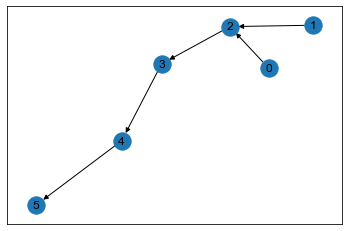

In [24]:
plot.graph(NX_GRAPHS['GBID10330'])

#### Alignment of 2 arbitrary graphs - Similarity Computation

In [22]:
unsup.edit_distance(NX_GRAPHS['GBID10271'], NX_GRAPHS['GBID10330'], node_attr = 'h', edge_attr = 'e', upper_bound = 100)

16.400193805630785

#### Unsupervised Learning

In [9]:
sim_matrix = unsup.similarity_matrix(dict_graphs = NX_GRAPHS)

In [42]:
embeddings = unsup.dimensionality_reduction(
    matrix = sim_matrix, 
    method = 'umap', 
    n_neighbors=3)

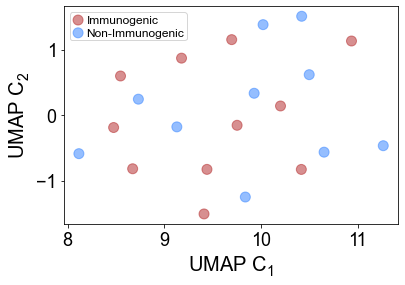

In [43]:
unsup.plot_embeddings(
    embeddings = embeddings, 
    NX_GRAPHS = NX_GRAPHS, 
    DF_PATH = DF_PATH, 
    method = 'UMAP')

**Load DGL dataset with labels and masks**

In [12]:
dgl_dict = MacroDataset(
    DF_PATH = DF_PATH, 
    SEED = SEED, 
    TASK = TASK, 
    LABELNAME = LABELNAME, 
    MODEL = MODEL, 
    NX_GRAPHS = NX_GRAPHS, 
    NORM = NORM)

#### Supervised learning 
Training model and obtaining validation and test metrics

In [13]:
random.seed(SEED)

macro_supervised = MacroSupervised(
    MacroDataset = dgl_dict, 
    MON_SMILES = MON_SMILES, 
    BOND_SMILES = BOND_SMILES, 
    FEAT = FEAT, 
    FP_BITS_MON = FP_BITS_MON, 
    FP_BITS_BOND = FP_BITS_BOND, 
    SEED = SEED, 
    MODEL = MODEL, 
    SPLIT = SPLIT, 
    NUM_EPOCHS = NUM_EPOCHS, 
    NUM_WORKERS = NUM_WORKERS, 
    CUSTOM_PARAMS = CUSTOM_PARAMS, 
    MODEL_PATH = MODEL_PATH, 
    SAVE_MODEL = SAVE_MODEL, 
    SAVE_OPT = SAVE_OPT, 
    SAVE_CONFIG = SAVE_CONFIG)

Directory ./ already exists.


In [14]:
macro_supervised.main()

epoch 1/10, batch 1/1, loss 0.6947
epoch 1/10, validation loss 0.6874, best validation loss 0.6874, validation ROC-AUC 0.6667, validation F1 0.7500, validation recall 0.7500, validation precision 0.7500, validation accuracy 0.7500
epoch 2/10, batch 1/1, loss 0.6780
EarlyStopping counter: 1 out of 30
epoch 2/10, validation loss 0.7039, best validation loss 0.6874, validation ROC-AUC 1.0000, validation F1 0.2500, validation recall 0.2500, validation precision 0.2500, validation accuracy 0.2500
epoch 3/10, batch 1/1, loss 0.6851
EarlyStopping counter: 2 out of 30
epoch 3/10, validation loss 0.7225, best validation loss 0.6874, validation ROC-AUC 1.0000, validation F1 0.2500, validation recall 0.2500, validation precision 0.2500, validation accuracy 0.2500
epoch 4/10, batch 1/1, loss 0.6811
EarlyStopping counter: 3 out of 30
epoch 4/10, validation loss 0.7402, best validation loss 0.6874, validation ROC-AUC 1.0000, validation F1 0.2500, validation recall 0.2500, validation precision 0.2500

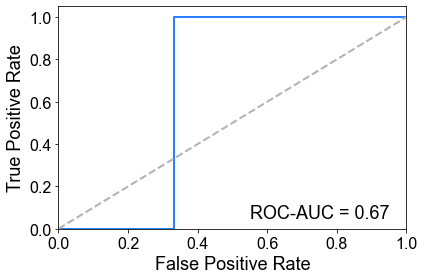

<Figure size 432x288 with 0 Axes>

In [15]:
macro_supervised.rocauc_plot('test', './')

#### Attribution

In [16]:
random.seed(SEED)
input_graph = dgl_dict.graphs[0]

attribution = Attribution(
    model_name = MODEL, 
    attribution_type = 'integrated_gradients')

attribution.calculate_attribution(
    model_instance = macro_supervised.model, 
    input_graph = input_graph)

{0: 'Xyl', 1: 'Gal', 2: 'Xyl', 3: 'Fuc', 4: 'Gal', 5: 'Xyl', 6: 'Xyl', 7: 'Glc', 8: 'Glc', 9: 'Glc', 10: 'Glc', 11: 'Glc'}
Key Monomer is Xyl


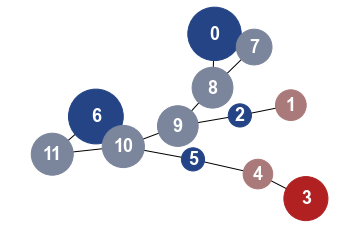

In [17]:
attribution.plot_graph(
    input_graph = input_graph, 
    NX_GRAPHS = NX_GRAPHS)

0 Xyl
Key Substructure in Xyl 16


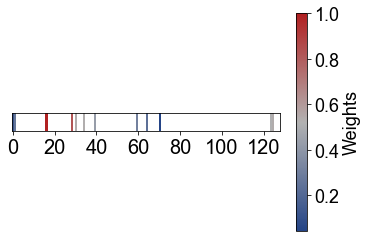

In [18]:
attribution.plot_fp(node_idx=0)

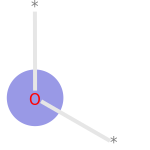

In [20]:
index = 16
mol, bi = attribution.display_substructure(
    monomer = 'Xyl', 
    MON_SMILES_PATH = MON_SMILES, 
    RADIUS = FP_RADIUS_MON, 
    N_BITS = FP_BITS_MON)
Draw.DrawMorganBit(mol, index, bi)